In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, UpSampling3D, Input, ZeroPadding3D, Lambda, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv3D, MaxPooling3D
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.constraints import unit_norm, max_norm
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf

from sklearn.model_selection import StratifiedKFold
import numpy as np
import nibabel as nib
import scipy as sp
import scipy.ndimage
from sklearn.metrics import mean_squared_error, r2_score

import sys
import argparse
import os
import glob 

import dcor

/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# In[2]:
def augment_by_transformation(data,age,sex,n):
    augment_scale = 1

    if n <= data.shape[0]:
        return data
    else:
        raw_n = data.shape[0]
        m = n - raw_n
        for i in range(0,m):
            new_data = np.zeros((1,data.shape[1],data.shape[2],data.shape[3],1))
            idx = np.random.randint(0,raw_n)
            new_age = age[idx]
            new_sex = sex[idx]
            new_data[0] = data[idx].copy()
            new_data[0,:,:,:,0] = sp.ndimage.interpolation.rotate(new_data[0,:,:,:,0],np.random.uniform(-1,1),axes=(1,0),reshape=False)
            new_data[0,:,:,:,0] = sp.ndimage.interpolation.rotate(new_data[0,:,:,:,0],np.random.uniform(-1,1),axes=(0,1),reshape=False)
            new_data[0,:,:,:,0] = sp.ndimage.shift(new_data[0,:,:,:,0],np.random.uniform(-1,1))
            data = np.concatenate((data, new_data), axis=0)
            age = np.append(age, new_age)
            sex = np.append(sex, new_sex)
        return data,age,sex

def inv_correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-7
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-7
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)

In [3]:
class GAN():
    
    def __init__(self):

        optimizer = Adam(0.0002)
        optimizer_distiller = Adam(0.0002)
        optimizer_regressor = Adam(0.0002)

        # Build and compile the cf predictorinv_inv
        self.regressor_age = self.build_regressor_age()
        self.regressor_age.compile(loss='mse', optimizer=optimizer_regressor)
        self.regressor_sex = self.build_regressor_sex()
        self.regressor_sex.compile(loss='binary_crossentropy', optimizer=optimizer_regressor)
        
        # Build the feature encoder
        input_feature = Input(shape=(64*3,), name='input_image')
        feature_dense = Dense(64,activation='tanh')(input_feature)
        
        self.encoder = Model(input_feature, feature_dense)
        
        # For the distillation model we will only train the encoder

        self.regressor_age.trainable = False
        cf_age = self.regressor_age(feature_dense)
        self.distiller_age = Model(input_feature, cf_age)
        self.distiller_age.compile(loss=correlation_coefficient_loss, optimizer=optimizer_distiller)

        self.regressor_sex.trainable = False
        cf_sex = self.regressor_sex(feature_dense)
        self.distiller_sex = Model(input_feature, cf_sex)
        self.distiller_sex.compile(loss=correlation_coefficient_loss, optimizer=optimizer_distiller)
        
        # Build and Compile the classifer   
        feature_clf = Dense(16, activation='tanh')(feature_dense)
        label = Dense(1, activation='sigmoid', name='r_mean')(feature_clf)
        
        self.classifier = Model(input_feature, label)
        self.classifier.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

        
    def build_regressor_age(self):
        inputs_x = Input(shape=(64,))
        feature = Dense(16, activation='tanh')(inputs_x)
        cf = Dense(1)(feature)

        return Model(inputs_x, cf)
    
    def build_regressor_sex(self):
        inputs_x = Input(shape=(64,))
        feature = Dense(16, activation='tanh')(inputs_x)
        cf = Dense(1,activation='sigmoid')(feature)

        return Model(inputs_x, cf)

    def train(self, epochs, training, testing, testing_raw, batch_size=64, fold=0):
        [train_data_aug, train_dx_aug, train_age_aug, train_sex_aug] = training
        [test_data_aug,  test_dx_aug,  test_age_aug,  test_sex_aug]  = testing
        [test_data    ,  test_dx    ,  test_age,      test_sex   ]   = testing_raw
        
        dc_age = np.zeros((int(epochs/100),))
        dc_sex = np.zeros((int(epochs/100),))
        dc = np.zeros((int(epochs/100),))
        for epoch in range(epochs):

            # ---------------------
            #  Train Disstiller
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, int(train_data_aug.shape[0]/2), int(batch_size/2))
            idx = np.concatenate((idx,idx+int(train_data_aug.shape[0]/2)))
 
            training_feature_batch = train_data_aug[idx]
            dx_batch = train_dx_aug[idx]
            age_batch = train_age_aug[idx]

            training_feature_ctrl_batch = training_feature_batch[dx_batch == 0]
            age_ctrl_batch = age_batch[dx_batch == 0]
            
            # Train the discriminator
            encoded_feature_ctrl_batch = self.encoder.predict(training_feature_ctrl_batch)
            #r_loss = self.regressor.train_on_batch(encoded_feature_ctrl_batch, age_ctrl_batch)

            # ---------------------
            #  Train Encoder & Classifier
            # ---------------------
            c_loss = self.classifier.train_on_batch(training_feature_batch, dx_batch)            
            #g_loss = self.distiller.train_on_batch(training_feature_ctrl_batch, age_ctrl_batch)


            c_loss_test = self.classifier.evaluate(test_data_aug, test_dx_aug, verbose = 0, batch_size = batch_size)    

            # Plot the progress
            if epoch % 100 == 0:
                # feature dist corr
                features_dense = self.encoder.predict(test_data_aug,  batch_size = batch_size)
                #[dc, pval] = distcorr(features_dense[test_dx_aug==0], test_age_aug[test_dx_aug==0])
                test_cf_aug = np.vstack([test_age_aug,test_sex_aug]).T
                dc_age[int(epoch/100)] = dcor.u_distance_correlation_sqr(features_dense[test_dx_aug==0], test_age_aug[test_dx_aug==0])
                dc_sex[int(epoch/100)] = dcor.u_distance_correlation_sqr(features_dense[test_dx_aug==0], test_sex_aug[test_dx_aug==0])
                dc[int(epoch/100)] = dcor.u_distance_correlation_sqr(features_dense[test_dx_aug==0], test_cf_aug[test_dx_aug==0])
                
                #print ("%d [Cov: %f, DC: %f, p: %f, Acc: %f,  Test Acc: %f]" % (epoch, g_loss, dc, pval, c_loss[1], c_loss_test[1]))
                print ("%d [DC: %f %f %f, Acc: %f,  Test Acc: %f]" % (epoch, dc_age[int(epoch/100)], dc_sex[int(epoch/100)], dc[int(epoch/100)], c_loss[1], c_loss_test[1]))
                
                sys.stdout.flush()

        return dc_age,dc_sex,dc
    
    def train_cf_free(self, epochs, training, testing, testing_raw, batch_size=64, fold=0):
        [train_data_aug, train_dx_aug, train_age_aug, train_sex_aug] = training
        [test_data_aug,  test_dx_aug,  test_age_aug,  test_sex_aug]  = testing
        [test_data    ,  test_dx    ,  test_age,      test_sex   ]   = testing_raw
            
        dc_age = np.zeros((int(epochs/100),))
        dc_sex = np.zeros((int(epochs/100),))
        dc = np.zeros((int(epochs/100),))
        for epoch in range(epochs):

            # ---------------------
            #  Train Disstiller
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, int(train_data_aug.shape[0]/2), int(batch_size/2))
            idx = np.concatenate((idx,idx+int(train_data_aug.shape[0]/2)))
 
            training_feature_batch = train_data_aug[idx]
            dx_batch = train_dx_aug[idx]
            age_batch = train_age_aug[idx]
            sex_batch = train_sex_aug[idx]

            training_feature_ctrl_batch = training_feature_batch[dx_batch == 0]
            age_ctrl_batch = age_batch[dx_batch == 0]
            sex_ctrl_batch = sex_batch[dx_batch == 0]
            
            # Train the discriminator
            encoded_feature_ctrl_batch = self.encoder.predict(training_feature_ctrl_batch)
            r_loss_age = self.regressor_age.train_on_batch(encoded_feature_ctrl_batch, age_ctrl_batch)
            r_loss_sex = self.regressor_sex.train_on_batch(encoded_feature_ctrl_batch, sex_ctrl_batch)

            # ---------------------
            #  Train Encoder & Classifier
            # ---------------------
            c_loss = self.classifier.train_on_batch(training_feature_batch, dx_batch)            
            g_loss_age = self.distiller_age.train_on_batch(training_feature_ctrl_batch, age_ctrl_batch)
            g_loss_sex = self.distiller_sex.train_on_batch(training_feature_ctrl_batch, sex_ctrl_batch)


            c_loss_test = self.classifier.evaluate(test_data_aug, test_dx_aug, verbose = 0, batch_size = batch_size)    

            # Plot the progress
            if epoch % 100 == 0:
                # feature dist corr
                features_dense = self.encoder.predict(test_data_aug,  batch_size = batch_size)
                #[dc, pval] = distcorr(features_dense[test_dx_aug==0], test_age_aug[test_dx_aug==0])
                test_cf_aug = np.vstack([test_age_aug,test_sex_aug]).T
                dc_age[int(epoch/100)] = dcor.u_distance_correlation_sqr(features_dense[test_dx_aug==0], test_age_aug[test_dx_aug==0])
                dc_sex[int(epoch/100)] = dcor.u_distance_correlation_sqr(features_dense[test_dx_aug==0], test_sex_aug[test_dx_aug==0])
                dc[int(epoch/100)] = dcor.u_distance_correlation_sqr(features_dense[test_dx_aug==0], test_cf_aug[test_dx_aug==0])
                
                #print ("%d [Cov: %f, DC: %f, p: %f, Acc: %f,  Test Acc: %f]" % (epoch, g_loss, dc, pval, c_loss[1], c_loss_test[1]))
                print ("%d [DC: %f %f %f, Acc: %f,  Test Acc: %f]" % (epoch, dc_age[int(epoch/100)], dc_sex[int(epoch/100)], dc[int(epoch/100)], c_loss[1], c_loss_test[1]))
                
                sys.stdout.flush()
        return dc_age,dc_sex,dc

In [4]:
np.random.seed(2)

N = 256 # number of subjects in a group
M = 64 # batch of features

age_offset = 1
feature_offset = 1
noise = 1

## age difference between 2 groups
age1 = np.random.normal(0,1,size=N)
age2 = np.random.normal(age_offset,1,size=N)

## age difference between 2 groups
age1 = np.random.normal(0,1,size=N)
age2 = np.random.normal(age_offset,1,size=N)

## sex difference between 2 groups
sex1 = np.random.binomial(size=(N,), n=1, p = 0.75)
sex2 = np.random.binomial(size=(N,), n=1, p = 0.25)

## simulate features
x1 = np.zeros((N,M*3))
x2 = np.zeros((N,M*3))

## cf_free features
x1[:,0:M] = np.random.normal(0,  noise, size=(N,M))
x2[:,0:M] = np.random.normal(feature_offset,  noise, size=(N,M))

## age confounded features
for i in range(M):
    slope = np.random.normal(0,1)
    x1[:,i+M] = age1 * slope + np.random.normal(0,noise,size=(N,))
    x2[:,i+M] = age2 * slope + np.random.normal(0,noise,size=(N,))

## sex confounded features
for i in range(M):
    x1[:,i+2*M] = sex1 + np.random.normal(0,noise,size=(N,))
    x2[:,i+2*M] = sex2 + np.random.normal(0,noise,size=(N,))
    
## combinging the two groups
x = np.concatenate([x1,x2])
age = np.concatenate([age1,age2])
sex = np.concatenate([sex1,sex2])
dx = np.zeros((N*2,))
dx[N:] = 1

import matplotlib
import matplotlib.pyplot as plt

plt.imshow(x)
plt.show()

In [5]:
gan = GAN()
[dc_age,dc_sex,dc] = gan.train(epochs=10000, 
               training=[x, dx, age, sex], 
               testing=[x, dx, age, sex], 
               testing_raw=[x, dx, age, sex], batch_size=128, fold=0)

gan_cf = GAN()
[dc_age_cf_free,dc_sex_cf_free,dc_cf_free] = gan_cf.train_cf_free(epochs=10000, 
                          training=[x, dx, age, sex], 
                          testing=[x, dx, age, sex], 
                        testing_raw=[x, dx, age, sex], batch_size=128, fold=0)

0 [DC: 0.654999 0.177682 0.685407, Acc: 0.679688,  Test Acc: 0.671875]
100 [DC: 0.594218 0.254530 0.655644, Acc: 0.921875,  Test Acc: 0.953125]
200 [DC: 0.572328 0.275344 0.641593, Acc: 0.976562,  Test Acc: 0.980469]
300 [DC: 0.559866 0.284532 0.633164, Acc: 1.000000,  Test Acc: 0.990234]
400 [DC: 0.559639 0.275624 0.630204, Acc: 1.000000,  Test Acc: 0.998047]
500 [DC: 0.560243 0.274136 0.629648, Acc: 1.000000,  Test Acc: 1.000000]
600 [DC: 0.563520 0.273136 0.632089, Acc: 1.000000,  Test Acc: 1.000000]
700 [DC: 0.567881 0.266540 0.633514, Acc: 1.000000,  Test Acc: 1.000000]
800 [DC: 0.570150 0.264381 0.634601, Acc: 1.000000,  Test Acc: 1.000000]
900 [DC: 0.572351 0.263541 0.635997, Acc: 1.000000,  Test Acc: 1.000000]
1000 [DC: 0.573977 0.260685 0.636419, Acc: 1.000000,  Test Acc: 1.000000]
1100 [DC: 0.575844 0.258885 0.637493, Acc: 1.000000,  Test Acc: 1.000000]
1200 [DC: 0.577725 0.257588 0.638790, Acc: 1.000000,  Test Acc: 1.000000]
1300 [DC: 0.579112 0.257790 0.640118, Acc: 1.00000

/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [DC: 0.684569 0.185568 0.713005, Acc: 0.609375,  Test Acc: 0.640625]
100 [DC: 0.650984 0.253870 0.706810, Acc: 0.960938,  Test Acc: 0.958984]
200 [DC: 0.528885 0.304756 0.607332, Acc: 0.976562,  Test Acc: 0.988281]
300 [DC: 0.472596 0.367933 0.577681, Acc: 1.000000,  Test Acc: 0.998047]
400 [DC: 0.394404 0.430713 0.526345, Acc: 1.000000,  Test Acc: 1.000000]
500 [DC: 0.342257 0.391267 0.466623, Acc: 1.000000,  Test Acc: 1.000000]
600 [DC: 0.472004 0.299493 0.557973, Acc: 1.000000,  Test Acc: 1.000000]
700 [DC: 0.498945 0.221488 0.556962, Acc: 1.000000,  Test Acc: 1.000000]
800 [DC: 0.446699 0.235121 0.509909, Acc: 1.000000,  Test Acc: 1.000000]
900 [DC: 0.431963 0.213009 0.489304, Acc: 1.000000,  Test Acc: 1.000000]
1000 [DC: 0.337842 0.189067 0.389990, Acc: 1.000000,  Test Acc: 1.000000]
1100 [DC: 0.292988 0.175072 0.340860, Acc: 1.000000,  Test Acc: 1.000000]
1200 [DC: 0.244694 0.147174 0.283270, Acc: 1.000000,  Test Acc: 1.000000]
1300 [DC: 0.202741 0.132105 0.238348, Acc: 1.00000

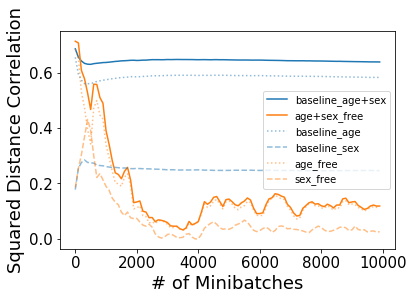

In [6]:
x = np.array(range(100))*100
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ax.plot(x,dc,x,dc_cf_free)
ax.plot(x,dc_age,color='tab:blue',linestyle=':',alpha=0.5)
ax.plot(x,dc_sex,color='tab:blue',linestyle='--',alpha=0.5)
ax.plot(x,dc_age_cf_free,color='tab:orange',linestyle=':',alpha=0.5)
ax.plot(x,dc_sex_cf_free,color='tab:orange',linestyle='--',alpha=0.5)

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(['baseline_age+sex','age+sex_free','baseline_age','baseline_sex','age_free','sex_free'])
plt.xlabel('# of Minibatches', fontsize=18)
plt.ylabel('Squared Distance Correlation', fontsize=18)
plt.show()

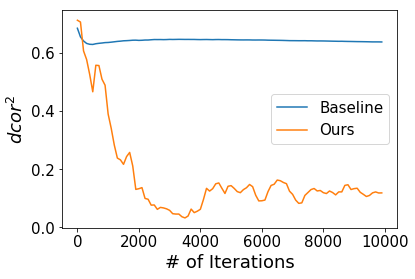

In [11]:
x = np.array(range(100))*100
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ax.plot(x,dc,x,dc_cf_free)
#ax.plot(x,dc_age,color='tab:blue',linestyle=':',alpha=0.5)
#ax.plot(x,dc_sex,color='tab:blue',linestyle='--',alpha=0.5)
#ax.plot(x,dc_age_cf_free,color='tab:orange',linestyle=':',alpha=0.5)
#ax.plot(x,dc_sex_cf_free,color='tab:orange',linestyle='--',alpha=0.5)

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(['Baseline','Ours'], fontsize=15)
plt.xlabel('# of Iterations', fontsize=18)
plt.ylabel('$dcor^2$', fontsize=18)
plt.show()